In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import datetime as dt
from scipy import stats
import yfinance as yf
import time
sns.set_style('whitegrid')
%matplotlib inline

In [46]:
tickers=['AAPL','MSFT','GOOGL','AMZN']
weights=np.array([0.25,0.25,0.25,0.25])#equal-weight portfolio

start = dt.datetime(2020,1,1)
end=dt.datetime.today()

#Container for adjusted close price
prices=pd.DataFrame()

for ticker in tickers:
    print(f"Fetching {ticker}...",end=" ")
    try:
        #pull via yfinance.Ticker.history (auto_adjust-> splits/divs handled)
        df=yf.Ticker(ticker).history(
            start=start.strftime('%Y-%m-%d'),
            end=end.strftime('%Y-%m-%d'),
            auto_adjust=True,
        )
        series=df['Close']
        print(">> yfinane",end="")
    except Exception as e:
        #fallback to Stooq if yfinance falls
        print(f"X yfinance ({e}); falling back to Stooq",end="")
        df2=pdr.DataReader(ticker,'stooq',start,end)
        df2=df2.sort_index()
        series = df2['Close']

    #align on our master
    prices[ticker]=series
    time.sleep(1)
    print()

#drop leading NaNs if any , then forward-fill/back-fill gaps
prices=prices.dropna(how='all').ffill().bfill()

#quick sanity check
print(prices.tail())

Fetching AAPL... >> yfinane
Fetching MSFT... >> yfinane
Fetching GOOGL... >> yfinane
Fetching AMZN... >> yfinane
                                 AAPL        MSFT       GOOGL        AMZN
Date                                                                     
2025-06-17 00:00:00-04:00  195.639999  478.040009  175.949997  214.820007
2025-06-18 00:00:00-04:00  196.580002  480.239990  173.320007  212.520004
2025-06-20 00:00:00-04:00  201.000000  477.399994  166.639999  209.690002
2025-06-23 00:00:00-04:00  201.500000  486.000000  165.190002  208.470001
2025-06-24 00:00:00-04:00  200.300003  490.109985  166.770004  212.770004


In [47]:
prices.head()

,AAPL,MSFT,GOOGL,AMZN
Date,,,,
2020-01-02 00:00:00-05:00,72.620834,153.042282,68.026024,94.900497
2020-01-03 00:00:00-05:00,71.914810,151.136658,67.670151,93.748497
2020-01-06 00:00:00-05:00,72.487846,151.527298,69.473846,95.143997
2020-01-07 00:00:00-05:00,72.146927,150.145767,69.339645,95.343002
2020-01-08 00:00:00-05:00,73.307510,152.537292,69.833183,94.598503


In [48]:
#log-return = ln(p_t/P_(t-1))
logR=np.log(prices/prices.shift(1)).dropna()
logR.head()

,AAPL,MSFT,GOOGL,AMZN
Date,,,,
2020-01-03 00:00:00-05:00,-0.009770,-0.012530,-0.005245,-0.012213
2020-01-06 00:00:00-05:00,0.007937,0.002581,0.026305,0.014776
2020-01-07 00:00:00-05:00,-0.004714,-0.009159,-0.001934,0.002089
2020-01-08 00:00:00-05:00,0.015958,0.015803,0.007092,-0.007839
2020-01-09 00:00:00-05:00,0.021019,0.012415,0.010443,0.004788


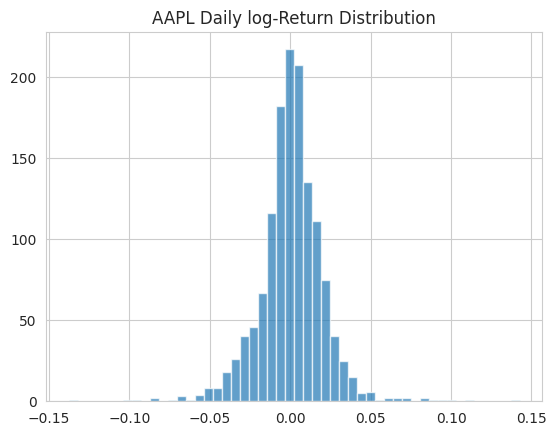

In [49]:
#Plot one example series for visual Check
# You'll see a bell-shaped histogram.
logR['AAPL'].hist(bins=50,alpha=0.7)
plt.title('AAPL Daily log-Return Distribution')
plt.show()

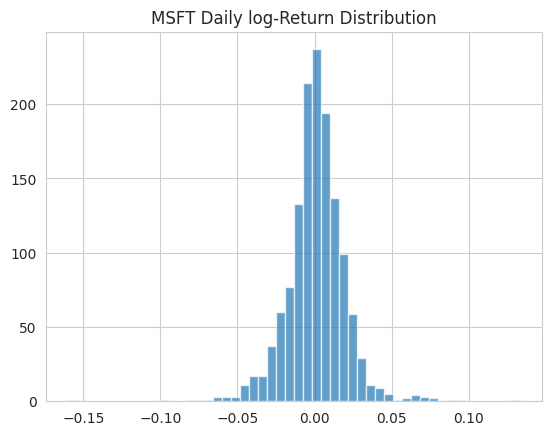

In [50]:
#Plot one example series for visual Check
# You'll see a bell-shaped histogram.
logR['MSFT'].hist(bins=50,alpha=0.7)
plt.title('MSFT Daily log-Return Distribution')
plt.show()

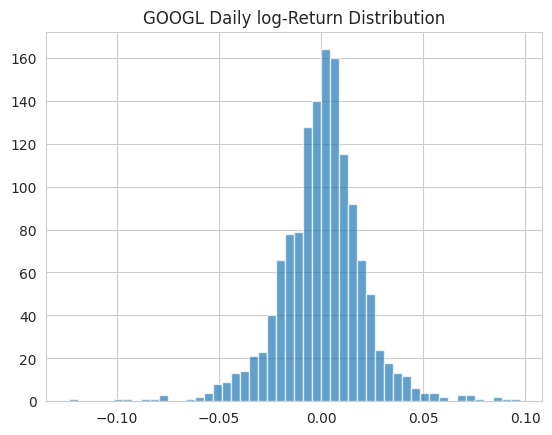

In [51]:
#Plot one example series for visual Check
# You'll see a bell-shaped histogram.
logR['GOOGL'].hist(bins=50,alpha=0.7)
plt.title('GOOGL Daily log-Return Distribution')
plt.show()

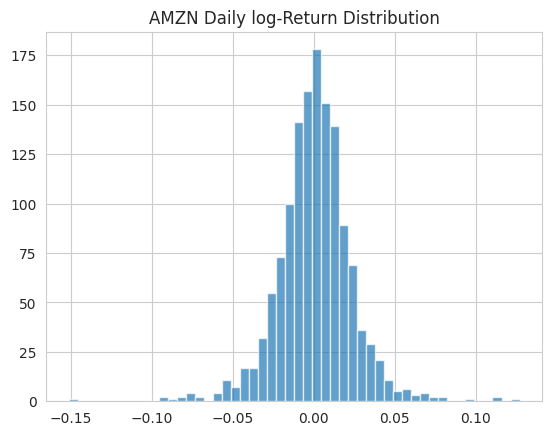

In [52]:
#Plot one example series for visual Check
# You'll see a bell-shaped histogram.
logR['AMZN'].hist(bins=50,alpha=0.7)
plt.title('AMZN Daily log-Return Distribution')
plt.show()

In [53]:
summary=pd.DataFrame({
    'Mean': logR.mean(),
    'Variance':logR.var(),
    'Skewness':logR.skew(),
    'Kurtosis':logR.kurtosis()
})
summary

,Mean,Variance,Skewness,Kurtosis
AAPL,0.000738,0.000421,0.021784,6.257711
MSFT,0.000846,0.000368,-0.169921,7.521713
GOOGL,0.000652,0.000428,-0.224224,3.634326
AMZN,0.000587,0.000518,-0.070785,4.205239


In [54]:
mu_norm, sigma_norm=logR.stack().mean(), logR.stack().std(ddof=1)

N=logR.size
z95=stats.norm.ppf(0.975)
ci_mu_norm=(mu_norm-z95*sigma_norm/np.sqrt(N),
            mu_norm+z95*sigma_norm/np.sqrt(N))

df=N-1
chi2_low,chi2_high=stats.chi2.ppf([0.025,0.975],df)
ci_sigma_norm=(sigma_norm*np.sqrt(df/chi2_high),
               sigma_norm*np.sqrt(df/chi2_low))
print('Normal fit:')
print(f" mu={mu_norm:.5f}, 95% CI {ci_mu_norm}")
print(f"sigma={sigma_norm:.5f}, 95% CI{ci_sigma_norm}")

Normal fit:
 mu=0.00071, 95% CI (np.float64(0.00015554661581882617), np.float64(0.001256303617624223))
sigma=0.02083, 95% CI(np.float64(0.020443453380936786), np.float64(0.02122212961618997))


In [55]:
# 4.2 Fit student's t

# Fit t-distribution to the log-returns
# return_flat = all asset return concatenated
returns_flat = logR.stack().values
df_t, mu_t, sigma_t = stats.t.fit(returns_flat)

In [56]:
B = 1000  # Number of bootstrap samples
estimates = np.array(([stats.t.fit(np.random.choice(returns_flat, size=N, replace=True)) for _ in range(B)]))

ci_um_t = np.percentile(estimates[:, 1], [2.5, 97.5])
ci_sigma_t = np.percentile(estimates[:, 2], [2.5, 97.5])

df_t, mu_t, sigma_t = stats.t.fit(returns_flat)

print('Student\'s t fit:')
print(f" df = {df_t:.1f}, μ = {mu_t:.5f}, σ = {sigma_t:.5f}")
print(f" 95% CI for μ (bootstrap): {ci_um_t}")
print(f" 95% CI for σ (bootstrap): {ci_sigma_t}")

Student's t fit:
 df = 3.7, μ = 0.00105, σ = 0.01440
 95% CI for μ (bootstrap): [0.00059652 0.0015036 ]
 95% CI for σ (bootstrap): [0.01391963 0.01488546]


In [57]:
# Parametric Var under Normal:
# Var = - [μ + σ * z(0.05)]
# where μ_p, σ_p are portfolio mean & vol.
# computer portfolio returns
portR = logR.dot(weights)  # logR is assumed to be a matrix of log returns

μ_p = portR.mean()
σ_p = portR.std(ddof=1)

z05 = stats.norm.ppf(0.05)
VaR_norm = -(μ_p + σ_p * z05)

In [58]:
t05 = stats.t.ppf(0.05, df_t)  # t-distribution quantile
VaR_t = -(mu_t + sigma_t * t05) * 1


In [59]:
# One-sample t-test: H0: μ=0 vs H1: μ≠0
t_stat, p_val = stats.ttest_1samp(portR, 0.0)

print("One-sample t-test on portfolio daily returns:")
print(f"   t-statistic = {t_stat:.3f},  p-value = {p_val:.3f}")

if p_val < 0.05:
    print("➜ Reject H₀: mean return is significantly different from zero.")
else:
    print("➜ Fail to reject H₀: no evidence mean return ≠ 0.")


One-sample t-test on portfolio daily returns:
   t-statistic = 1.449,  p-value = 0.148
➜ Fail to reject H₀: no evidence mean return ≠ 0.


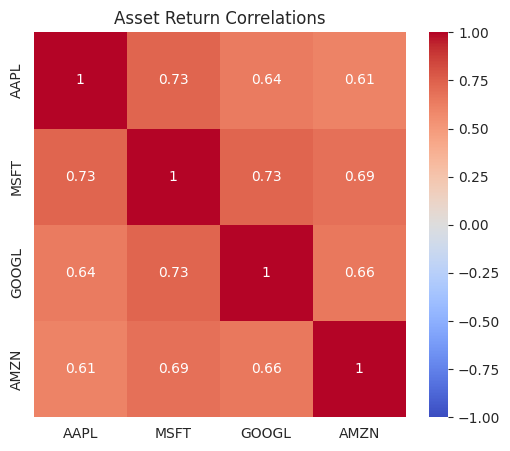

Weighted avg σ: 0.0208
Actual portfolio σ: 0.0181
Diversification benefit: 0.0027


In [60]:
# 7. Correlation & Diversification Benefit
import seaborn as sns

# a) Correlation heatmap
corr = logR.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Asset Return Correlations')
plt.show()

# b) Diversification benefit
σ_i = logR.std()                                # individual volatilities
σ_weighted = np.dot(weights, σ_i)               # naive weighted average
σ_portfolio = σ_p                               # from earlier (portfolio std deviation)

print(f"Weighted avg σ: {σ_weighted:.4f}")
print(f"Actual portfolio σ: {σ_portfolio:.4f}")
print(f"Diversification benefit: {σ_weighted - σ_portfolio:.4f}")


Max Drawdown: -43.98%
From 2021-12-10 to 2023-01-05


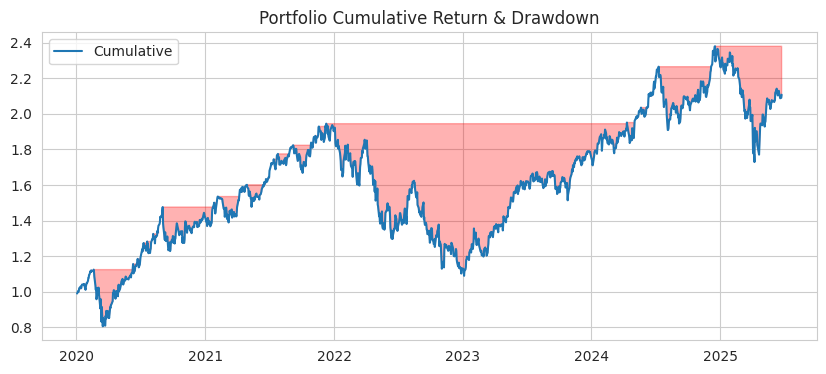

In [61]:
# 8. Max Drawdown

cum_ret = (prices / prices.iloc[0]).prod(axis=1)  # cumulative portfolio growth?

# Actually for portfolio:
cum_port = (portR + 1).cumprod()

rolling_max = cum_port.cummax()
drawdown = (cum_port - rolling_max) / rolling_max

max_dd = drawdown.min()
end_date = drawdown.idxmin()
start_date = cum_port[:end_date].idxmax()

print(f"Max Drawdown: {max_dd:.2%}")
print(f"From {start_date.date()} to {end_date.date()}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(cum_port, label='Cumulative')
plt.fill_between(drawdown.index, cum_port, rolling_max, where=drawdown < 0, color='red', alpha=0.3)
plt.title('Portfolio Cumulative Return & Drawdown')
plt.legend()
plt.show()


In [62]:
# 9. Expect shortfall (CvaR at 95%)
alpha = 0.05

# Historical ES (make it positive)
es_hist = -portR[portR <= np.percentile(portR, 5)].mean()

# Parametric ES under Normal: μ + σ * φ(z) / α
es_norm = - (μ_p - σ_p * stats.norm.pdf(z05) / alpha)

print(f"Historical ES (95%): {es_hist:.5f}")
print(f"Parametric Normal ES (95%): {es_norm:.5f}")


Historical ES (95%): 0.04210
Parametric Normal ES (95%): 0.03655


In [63]:
# 10. VaR Backtesting

var_series = - (portR.rolling(1).mean() + portR.rolling(1).std() * z05)

# For simplicity use constant VaR_norm
exceptions = portR < -VaR_norm
num_exc = exceptions.sum()
total = len(portR)

print(f"Exceptions: {num_exc}/{total} days ({num_exc/total:.2%}, expected ~5%)")

Exceptions: 67/1375 days (4.87%, expected ~5%)


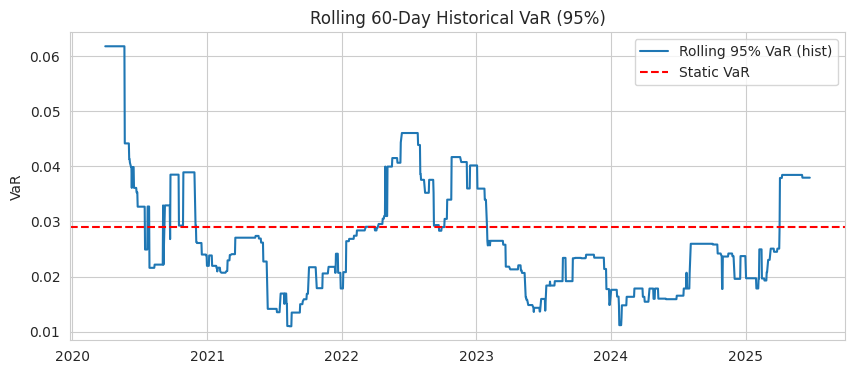

In [65]:
# 11. Rolling 60-day VaR

window = 60
roll_var = portR.rolling(window).quantile(0.05).dropna()

plt.figure(figsize=(10, 4))
plt.plot(-roll_var, label='Rolling 95% VaR (hist)')

plt.axhline(VaR_norm, color='red', linestyle='--', label='Static VaR')

plt.title('Rolling 60-Day Historical VaR (95%)')
plt.ylabel('VaR')
plt.legend()
plt.show()


In [66]:
# 12. Jarque-Bera Normality Test
jb_stat, jb_p = stats.jarque_bera(portR)

print(f"JB statistic = {jb_stat:.2f}, p-value = {jb_p:.3f}")

if jb_p < 0.05:
    print("Reject normality at 5% level.")
else:
    print("Cannot reject normality.")


JB statistic = 1239.56, p-value = 0.000
Reject normality at 5% level.
